In [356]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import pandas as pd
import re
import matplotlib as mlt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [357]:
#import excel
transactionData = pd.read_excel (r'D:\quantiumproject\QVI_transaction_data.xlsx') 
customerData = pd.read_csv (r'D:\quantiumproject\QVI_purchase_behaviour.csv')


#excel time to python date
from datetime import datetime
import xlrd
def to_date(x):
    return xlrd.xldate_as_datetime(x, 0).date().strftime('%Y/%m/%d')
    
transactionData["DATE"] = transactionData["DATE"].apply(to_date)

In [358]:
transactionData

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018/10/17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019/05/14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019/05/20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018/08/17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018/08/18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019/03/09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018/08/13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018/11/06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018/12/27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [359]:
#test if all product are chips
unique_product =pd.DataFrame(transactionData["PROD_NAME"].unique(),columns ={"products"})
words = unique_product['products'].str.lower().str.split().sum()
words_removed =pd.DataFrame([x for x in words if x.isalpha()])
pd.set_option('display.max_rows', 500) 
words_removed.value_counts()
#remove salse products
transactionData2 = transactionData[transactionData["PROD_NAME"].str.lower().str.contains("salsa") ==False]
transactionData2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246742 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            246742 non-null  object 
 1   STORE_NBR       246742 non-null  int64  
 2   LYLTY_CARD_NBR  246742 non-null  int64  
 3   TXN_ID          246742 non-null  int64  
 4   PROD_NBR        246742 non-null  int64  
 5   PROD_NAME       246742 non-null  object 
 6   PROD_QTY        246742 non-null  int64  
 7   TOT_SALES       246742 non-null  float64
dtypes: float64(1), int64(5), object(2)
memory usage: 16.9+ MB


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018/08/19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019/05/20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


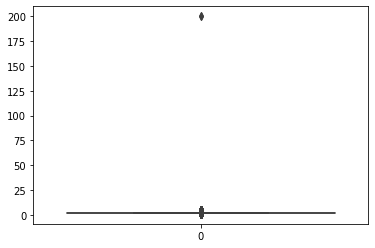

In [360]:
#filter dataset to find outlier
"""
Note: There are two transactions where 200 packets of chips are bought in one transaction
and both of these transactions were by the same customer. 
"""
import seaborn as sns
import matplotlib.pyplot as plt
transactionData2.agg(
    {
        "PROD_QTY": ["min", "max", "median", "mean","skew"],
        "TOT_SALES": ["min", "max", "median", "mean","skew"],
    }
)
sns.boxplot(data =transactionData2["PROD_QTY"])
purchaseOutlier = transactionData2[transactionData2["PROD_QTY"]==200]
purchaseOutlier


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018/10/17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019/05/14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019/05/20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018/08/17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018/08/18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019/03/09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018/08/13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018/11/06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018/12/27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


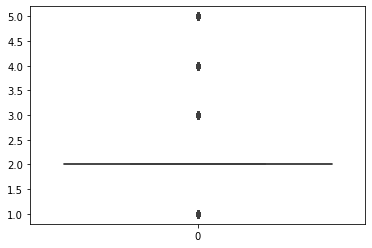

In [361]:
"""
Note: It looks like this customer has only had the two transactions over the year and is 
not an ordinary retail customer. The customer might be buying chips for commercial 
purposes instead. 
We'll remove this loyalty card number from further analysis.
"""
#remove outlier by index
transactionData2[transactionData2["LYLTY_CARD_NBR"]==226000]
customerIndex =transactionData2[transactionData2["LYLTY_CARD_NBR"]==226000].index.tolist()
transactionData3 = transactionData2.drop(customerIndex)
sns.boxplot(data =transactionData3["PROD_QTY"])
transactionData3


In [362]:
# count number of transaction by date, detect missing date
transactionData3.groupby(by =["DATE"]).sum()
#date serieswe have
temp_date =transactionData3["DATE"].unique().tolist()
#full date series
dateSeris =pd.date_range(start ='7/1/2018', end='6/30/2019').strftime('%Y/%m/%d')
temp_date_full =dateSeris.tolist()
missing_date=pd.DataFrame( [i for i in temp_date_full if i not in temp_date], columns=["DATE"])


<AxesSubplot:xlabel='DATE'>

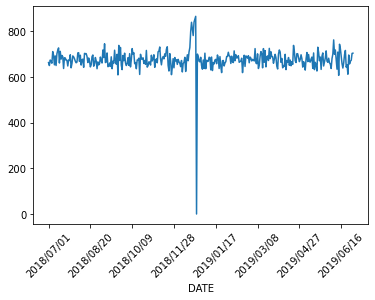

In [363]:
"""
We can see that there is an increase in purchases in December and a break in late
December. Let's zoom in on this.
"""
df_complete = pd.concat([transactionData3,missing_date],axis =0).sort_values(by="DATE")
df_sale = df_complete.groupby(by="DATE").size()
df_sale.plot(rot =45)


<AxesSubplot:xlabel='DATE'>

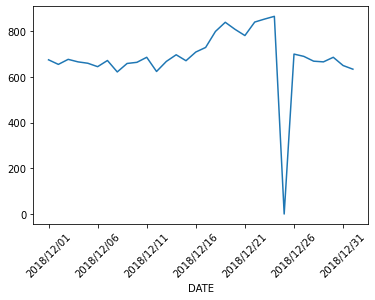

In [364]:
#### zoom in: Filter to December and look at individual days
"""
We can see that the increase in sales occurs in the lead-up to Christmas and that
there are zero sales on Christmas day itself. This is due to shops being closed on
Christmas day.

Now that we are satisfied that the data no longer has outliers, we can move on to
creating other features such as brand of chips or pack size from PROD_NAME. We will
start with pack size.
"""
dec_series =pd.date_range(start ='12/1/2018', end='1/1/2019').strftime('%Y/%m/%d')
df_december = df_complete.loc[df_complete["DATE"].isin([ i for i in dec_series.tolist()])]
df_december_sale = df_december.groupby(by="DATE").size()
df_december_sale.plot(rot=45)


In [365]:
"""
Pack sizes 
"""
import re
def remove_nonint(x):
    return re.sub("[^0-9]","",str(x))
    
name_list = df_complete["PROD_NAME"].tolist()
output =list(map(remove_nonint, name_list))
output =list(filter(None,output))
output_int =list(map(int,output))

In [366]:
#min size
sorted(output_int)[0] 
#max size
sorted(output_int)[-1] 

380

<AxesSubplot:xlabel='PACK_SIZE'>

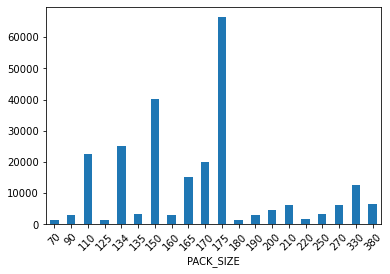

In [367]:
df_output =pd.DataFrame(output_int,columns=["PACK_SIZE"])
#df_output.groupby(by="PACK_SIZE").size().plot()
#df_output.plot.hist(bins=100)
#vertical bar plot
df_output.groupby(by="PACK_SIZE").size().plot(kind="bar",rot =45)


In [368]:
df_output

,PACK_SIZE
0,175
1,190
2,175
3,134
4,175
...,...
246735,175
246736,330
246737,170
246738,134


In [384]:
df_complete =df_complete.dropna()
df_complete = df_complete.reset_index(col_level =0)
df_complete =df_complete.drop('index',1)
df_complete.iloc[120460:120466]



,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
120460,2018/12/24,23.0,23099.0,19353.0,21.0,WW Sour Cream &OnionStacked Chips 160g,2.0,3.8,160.0
120461,2018/12/24,225.0,225226.0,226039.0,4.0,Dorito Corn Chp Supreme 380g,2.0,13.0,380.0
120462,2018/12/24,191.0,191066.0,192172.0,70.0,Tyrrells Crisps Lightly Salted 165g,2.0,8.4,165.0
120463,2018/12/24,230.0,230139.0,232844.0,29.0,French Fries Potato Chips 175g,2.0,6.0,175.0
120464,2018/12/24,226.0,226380.0,228268.0,16.0,Smiths Crinkle Chips Salt & Vinegar 330g,2.0,11.4,330.0
120465,2018/12/26,48.0,48076.0,43511.0,7.0,Smiths Crinkle Original 330g,2.0,11.4,110.0


In [386]:

df_complete["PACK_SIZE"]=df_output
df_complete

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018/07/01,217.0,217068.0,216604.0,46.0,Kettle Original 175g,2.0,10.8,175
1,2018/07/01,197.0,197352.0,197323.0,18.0,Cheetos Chs & Bacon Balls 190g,2.0,6.6,190
2,2018/07/01,144.0,144001.0,143893.0,28.0,Thins Potato Chips Hot & Spicy 175g,2.0,6.6,175
3,2018/07/01,137.0,137009.0,138924.0,81.0,Pringles Original Crisps 134g,2.0,7.4,134
4,2018/07/01,153.0,153187.0,152684.0,28.0,Thins Potato Chips Hot & Spicy 175g,2.0,6.6,175
...,...,...,...,...,...,...,...,...,...
246734,2019/06/30,71.0,71016.0,68990.0,71.0,Twisties Cheese Burger 250g,2.0,8.6,250
246735,2019/06/30,69.0,69114.0,66549.0,37.0,Smiths Thinly Swt Chli&S/Cream175G,2.0,6.0,175
246736,2019/06/30,194.0,194228.0,194194.0,7.0,Smiths Crinkle Original 330g,2.0,11.4,330
246737,2019/06/30,144.0,144190.0,144916.0,30.0,Doritos Corn Chips Cheese Supreme 170g,2.0,8.8,170


In [393]:
"""
Brand name:
1. Create a column which contains the brand of the product, by
extracting it from the product name.(first word in PROD_NAME)

"""
transactionData_addbrand = df_complete
transactionData_addbrand["BRAND"] =transactionData_copy["PROD_NAME"].str.split().str[0]
transactionData_addbrand["BRAND"].unique()

array(['Kettle', 'Cheetos', 'Thins', 'Pringles', 'Doritos', 'Cobs', 'RRD',
       'Smiths', 'Infuzions', 'Cheezels', 'Burger', 'GrnWves', 'Tostitos',
       'Tyrrells', 'CCs', 'Twisties', 'WW', 'NCC', 'Smith', 'Red',
       'Dorito', 'French', 'Grain', 'Natural', 'Snbts', 'Infzns',
       'Sunbites', 'Woolworths'], dtype=object)

In [394]:
#check&clean branding names
transactionData_addbrand.loc[transactionData_addbrand["BRAND"] == 'Snbts',"BRAND"] ='Sunbites'
transactionData_addbrand.loc[transactionData_addbrand["BRAND"] == 'Red',"BRAND"] ='RRD'
transactionData_addbrand.loc[transactionData_addbrand["BRAND"] == 'Doritos',"BRAND"] ='Dorito'
transactionData_addbrand.loc[transactionData_addbrand["BRAND"] == 'WW',"BRAND"] ='Woolworths'
transactionData_addbrand.loc[transactionData_addbrand["BRAND"] == 'Infzns',"BRAND"] ='Infuzions'
transactionData_addbrand.loc[transactionData_addbrand["BRAND"] == 'NCC',"BRAND"] ='Natural'
transactionData_addbrand.loc[transactionData_addbrand["BRAND"] == 'Smiths',"BRAND"] ='Smith'
transactionData_addbrand.loc[transactionData_addbrand["BRAND"] == 'GrnWves',"BRAND"] ='Grain'
transactionData_addbrand["BRAND"].unique()
transactionData_final = transactionData_addbrand
transactionData_final

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018/07/01,217.0,217068.0,216604.0,46.0,Kettle Original 175g,2.0,10.8,175,Kettle
1,2018/07/01,197.0,197352.0,197323.0,18.0,Cheetos Chs & Bacon Balls 190g,2.0,6.6,190,Cheetos
2,2018/07/01,144.0,144001.0,143893.0,28.0,Thins Potato Chips Hot & Spicy 175g,2.0,6.6,175,Thins
3,2018/07/01,137.0,137009.0,138924.0,81.0,Pringles Original Crisps 134g,2.0,7.4,134,Pringles
4,2018/07/01,153.0,153187.0,152684.0,28.0,Thins Potato Chips Hot & Spicy 175g,2.0,6.6,175,Thins
...,...,...,...,...,...,...,...,...,...,...
246734,2019/06/30,71.0,71016.0,68990.0,71.0,Twisties Cheese Burger 250g,2.0,8.6,250,Twisties
246735,2019/06/30,69.0,69114.0,66549.0,37.0,Smiths Thinly Swt Chli&S/Cream175G,2.0,6.0,175,Smith
246736,2019/06/30,194.0,194228.0,194194.0,7.0,Smiths Crinkle Original 330g,2.0,11.4,330,Smith
246737,2019/06/30,144.0,144190.0,144916.0,30.0,Doritos Corn Chips Cheese Supreme 170g,2.0,8.8,170,Dorito


In [395]:
"""
check customer data
"""
data = pd.merge(customerData,transactionData_final)
data.info()
data.to_csv("D:/quantiumproject/QVI_data.csv")
"""
Now that the data is ready for analysis, we can define some metrics of interest to
the client:
- Who spends the most on chips (total sales), describing customers by lifestage and
how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment
"""

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246739 entries, 0 to 246738
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    246739 non-null  int64  
 1   LIFESTAGE         246739 non-null  object 
 2   PREMIUM_CUSTOMER  246739 non-null  object 
 3   DATE              246739 non-null  object 
 4   STORE_NBR         246739 non-null  float64
 5   TXN_ID            246739 non-null  float64
 6   PROD_NBR          246739 non-null  float64
 7   PROD_NAME         246739 non-null  object 
 8   PROD_QTY          246739 non-null  float64
 9   TOT_SALES         246739 non-null  float64
 10  PACK_SIZE         246739 non-null  int64  
 11  BRAND             246739 non-null  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 24.5+ MB


"\nNow that the data is ready for analysis, we can define some metrics of interest to\nthe client:\n- Who spends the most on chips (total sales), describing customers by lifestage and\nhow premium their general purchasing behaviour is\n- How many customers are in each segment\n- How many chips are bought per customer by segment\n- What's the average chip price by customer segment\n"

<AxesSubplot:xlabel='LIFESTAGE,PREMIUM_CUSTOMER'>

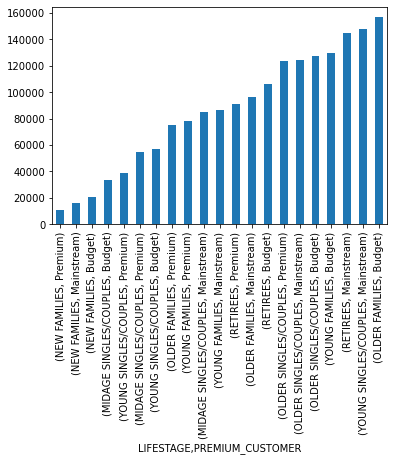

In [396]:
"""
task 1.1
Calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER
plotting the split by these segments
describe which customer segment contributemost to chip sales.
"""

sale_data = data.groupby(by=["LIFESTAGE","PREMIUM_CUSTOMER"]).sum()["TOT_SALES"].sort_values()
sale_data.plot(kind="bar",rot =90)

In [397]:
# Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
data.groupby(by=["LIFESTAGE","PREMIUM_CUSTOMER"]).sum()[["TOT_SALES","PROD_QTY"]]/data.groupby(by=["LIFESTAGE","PREMIUM_CUSTOMER"]).count()[["TOT_SALES","PROD_QTY"]]
"""
Older families and young families in general buy more chips per customer

"""
#the average price per unit chips bought for each customer segment as this is also a driver of total sales.
sale =data.groupby(by=["LIFESTAGE","PREMIUM_CUSTOMER"]).sum()[["TOT_SALES"]]
quantity =data.groupby(by=["LIFESTAGE","PREMIUM_CUSTOMER"]).sum()[["PROD_QTY"]]
sale["TOT_SALES"].divide(quantity["PROD_QTY"]).sort_values



<bound method Series.sort_values of LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              3.753878
                        Mainstream          3.994449
                        Premium             3.780823
NEW FAMILIES            Budget              3.931969
                        Mainstream          3.935887
                        Premium             3.886168
OLDER FAMILIES          Budget              3.747969
                        Mainstream          3.736380
                        Premium             3.717703
OLDER SINGLES/COUPLES   Budget              3.887529
                        Mainstream          3.822753
                        Premium             3.897698
RETIREES                Budget              3.932731
                        Mainstream          3.852986
                        Premium             3.924037
YOUNG FAMILIES          Budget              3.761903
                        Mainstream          3.722439
                      

In [398]:
unit_price=sale["TOT_SALES"].divide(quantity["PROD_QTY"])
unit_price

LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              3.753878
                        Mainstream          3.994449
                        Premium             3.780823
NEW FAMILIES            Budget              3.931969
                        Mainstream          3.935887
                        Premium             3.886168
OLDER FAMILIES          Budget              3.747969
                        Mainstream          3.736380
                        Premium             3.717703
OLDER SINGLES/COUPLES   Budget              3.887529
                        Mainstream          3.822753
                        Premium             3.897698
RETIREES                Budget              3.932731
                        Mainstream          3.852986
                        Premium             3.924037
YOUNG FAMILIES          Budget              3.761903
                        Mainstream          3.722439
                        Premium             3.759232
YOUNG

In [399]:
unit_price.loc["MIDAGE SINGLES/COUPLES"]

PREMIUM_CUSTOMER
Budget        3.753878
Mainstream    3.994449
Premium       3.780823
dtype: float64

In [400]:
unit_price.loc["YOUNG SINGLES/COUPLES"]

PREMIUM_CUSTOMER
Budget        3.685297
Mainstream    4.074089
Premium       3.692889
dtype: float64

In [401]:
# check if this difference is statistically different:
# #perform independent t-test between:(unit price)
# mainstream vs premium and budget midage and young singles and couples
import scipy
mainstreamY_midageSC = [4.074043,3.994449]
premium_budgetY_midageSC=[3.753878,3.780823,3.685297,3.692889]
scipy.stats.ttest_ind(mainstreamY_midageSC,premium_budgetY_midageSC)


Ttest_indResult(statistic=7.181829911420842, pvalue=0.0019909623590162917)

In [439]:
"""
we want to target customer segments that contribute the most to sales to 
retain them or further increase sales.

Let's look at Mainstream - young 
singles/couples, find out if they tend to buy a particular brand of chips.
"""
data_youngSC = data.loc[(data["LIFESTAGE"] == "YOUNG SINGLES/COUPLES")&(data["PREMIUM_CUSTOMER"] == "Mainstream")]
data_youngSC.groupby(by=["BRAND"]).sum()[["PROD_QTY","TOT_SALES"]].sort_values(by=["TOT_SALES"],ascending = False,axis=0)
data_youngSC.groupby(by=["BRAND"]).sum()[["PROD_QTY","TOT_SALES"]].sort_values(by=["TOT_SALES"],ascending = False,axis=0)

,PROD_QTY,TOT_SALES
BRAND,,
Kettle,7172.0,35423.6
Dorito,4447.0,20925.9
Pringles,4326.0,16006.2
Smith,3491.0,14958.9
Infuzions,2342.0,8747.0
Twisties,1673.0,7539.8
Tostitos,1645.0,7238.0
Thins,2187.0,7217.1
Cobs,1617.0,6144.6


<AxesSubplot:xlabel='PACK_SIZE'>

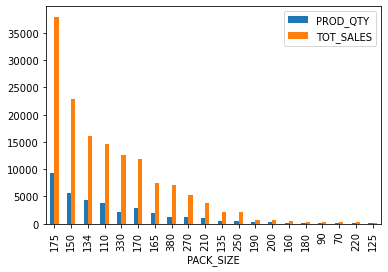

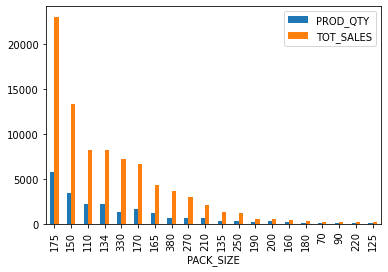

In [456]:
#Mainstream - young singles/couples.(pack size of chips)
data_youngSC = data.loc[(data["LIFESTAGE"] == "YOUNG SINGLES/COUPLES")&(data["PREMIUM_CUSTOMER"] == "Mainstream")]
pack_datayoung =data_youngSC.groupby(by =["PACK_SIZE"]).sum()[["PROD_QTY","TOT_SALES"]].sort_values(by=["TOT_SALES"],ascending = False,axis=0)
pack_datayoung.plot(kind="bar",rot =90)
#Mainstream - MIDAGE SINGLES/COUPLES.(pack size of chips)
data_midSC = data.loc[(data["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES")&(data["PREMIUM_CUSTOMER"] == "Mainstream")]
pack_datamid =data_midSC.groupby(by =["PACK_SIZE"]).sum()[["PROD_QTY","TOT_SALES"]].sort_values(by=["TOT_SALES"],ascending = False,axis=0)
pack_datamid.plot(kind="bar",rot =90)

,PROD_QTY,TOT_SALES
PACK_SIZE,,
175,65216.0,250291.00
150,39208.0,147343.10
134,24295.0,89880.40
110,21510.0,81730.40
170,19367.0,74346.00
330,12381.0,70571.70
165,14740.0,51370.40
380,6171.0,37957.05
270,6020.0,27692.00


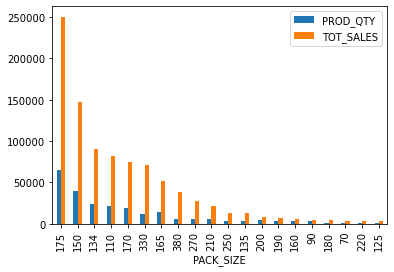

In [453]:
#prefered size of rest of the populations
data_rest = data.loc[(data["LIFESTAGE"] != "MIDAGE SINGLES/COUPLES")&(data["PREMIUM_CUSTOMER"] != "Mainstream")\
    &(data["LIFESTAGE"] != "YOUNG SINGLES/COUPLES")&(data["PREMIUM_CUSTOMER"] != "Mainstream")]

pack_datarest =data_rest.groupby(by =["PACK_SIZE"]).sum()[["PROD_QTY","TOT_SALES"]].sort_values(by=["TOT_SALES"],ascending = False,axis=0)
pack_datarest.plot(kind="bar",rot =90)
pack_datarest